# SECURE AUDIO CLASSIFICATION MODEL TRAINING (IN THE CLEAR)
using RAVDESS dataset of 1440 audio files and 1 modularity with 8 emotion labels.
link to dataset can be found at:
https://zenodo.org/record/1188976#.X7oCd81Kg2w



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install librosa

In [3]:

import librosa
from librosa import display
import os
import keras
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import scipy.io.wavfile
import sys
from sklearn.metrics import accuracy_score, confusion_matrix




In [ ]:
import time
path = '/content/drive/MyDrive/ravdess/audio_speech_actors_01-24'
lst = []
start_time = time.time()
for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      except ValueError:
        continue
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 1674.3116319179535 seconds ---


In [ ]:
X, y = zip(*lst)
X_name = 'XINPUT.joblib'
y_name = 'YINPUT.joblib'
save_dir = '/content/drive/My Drive'
savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
# Loading saved models
Xinput = joblib.load('/content/drive/My Drive/XINPUT.joblib')
Yinput = joblib.load('/content/drive/My Drive/YINPUT.joblib')

In [8]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(Xinput, Yinput, test_size=0.33, random_state=42)

In [9]:
x_train_data = np.expand_dims(X_train, axis=2)
x_test_data = np.expand_dims(X_test, axis=2)

In [10]:
x_train_data.shape, x_test_data.shape

((964, 40, 1), (476, 40, 1))

In [11]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop
model = Sequential()


model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(AveragePooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_22 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
average_pooling1d_7 (Average (None, 10, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 10, 128)           82048     
_________________________________________________________________
activation_23 (Activation)   (None, 10, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 128)          

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_train_data, y_train, batch_size=16, epochs=1000, validation_data=(x_train_data, y_test))

In [ ]:
predictions = model.predict_classes(x_test_data)

In [ ]:
predictions

In [ ]:
y_test

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

In [ ]:
model.save('/content/drive/MyDrive/models')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/assets


In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Emotion.h5')
loaded_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_22 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
average_pooling1d_7 (Average (None, 10, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 10, 128)           82048     
_________________________________________________________________
activation_23 (Activation)   (None, 10, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 128)          

In [12]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/My Drive/models')


In [15]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_testcnn).batch(1).take(476):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model('/content/drive/My Drive/models')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

loaded_model = keras.models.load_model('/content/drive/My Drive/models')

quant_model_accuracy = tflite_quant_model.evaluate(
   converter.representative_dataset, y_test, verbose=0)

baseline_model_accuracy = loaded_model.evaluate(
   x_test_data, y_test, verbose=0)

 print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))
 
print('Baseline test accuracy is %.4%%:', baseline_model_accuracy)
print('Quant test accuracy: is %.4%%', quant_model_accuracy)

Baseline test accuracy is 72.1100%
Quant test accuracy: is 70.3200%


Confusion Matrix:
0 - neutral, 1 - calm, 2 - happy, 3 - sad, 4 - angry, 5 - fearful, 6 - disgust, 7 - surprised


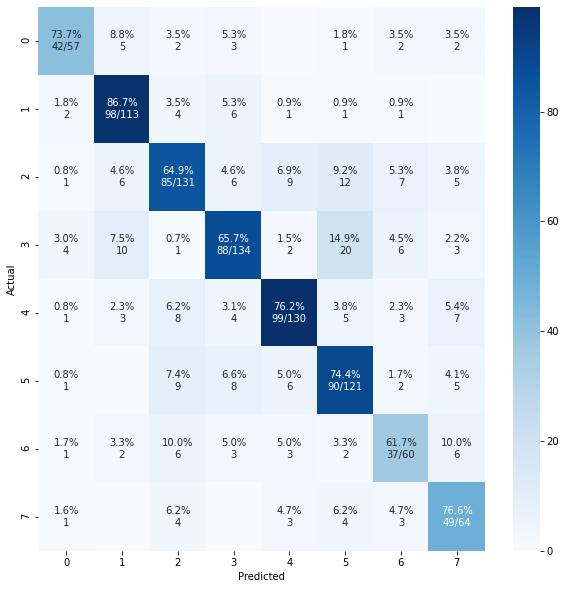

In [ ]:
#unquantized

matrix = confusion_matrix(y_test, predictions)
conf_mat_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('actual')
plt.xlabel('Predicted')


%matplotlib inline


def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test, predictions)
print("Confusion Matrix:")
print("0 - neutral, 1 - calm, 2 - happy, 3 - sad, 4 - angry, 5 - fearful, 6 - disgust, 7 - surprised")

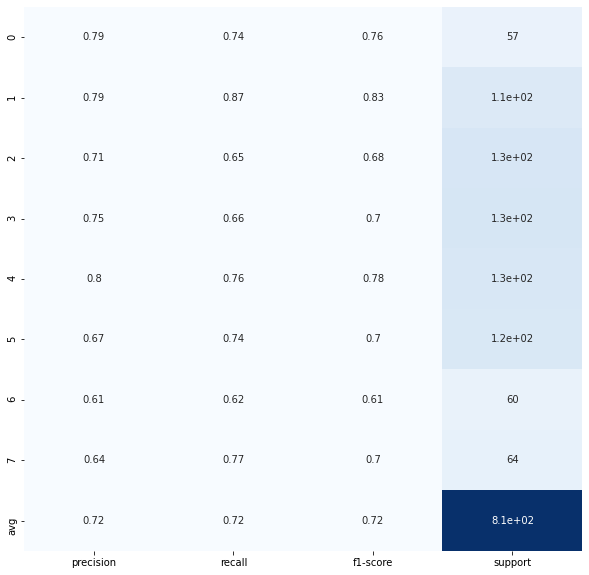

In [ ]:
#unquantized

def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,cmap = "Blues",
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

plot_classification_report(y_test, predictions)
# 0 - neutral, 1 - calm, 2 - happy, 3 - sad, 4 - angry, 5 - fearful, 6 - disgust, 7 - surprised